In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys

sys.path.insert(0, '/content/gdrive/My Drive/twitter_sentiment/') # This enables us to import Python libraries in the folder.

root_folder = "/content/gdrive/My Drive/twitter_sentiment/"

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=02843e6f7f0f37e359aee78897eb16678d153037a04f15c6080f5707b8bd086f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import wget
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prep Data

## GLoVe Embeddings

In [6]:
url = 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'

if not os.path.exists(root_folder + 'glove.twitter.27B.zip'):
    wget.download(url, root_folder + 'glove.twitter.27B.zip')
    
print('Dataset Downloaded')

Dataset Downloaded


In [7]:
if not os.path.exists(root_folder + 'glove_twitter'):
    !unzip "/content/gdrive/My Drive/twitter_sentiment/glove.twitter.27B.zip" -d "/content/gdrive/My Drive/twitter_sentiment/glove_twitter"
print('Glove Unzipped')

Glove Unzipped


## Sentiment140 Training Data

In [8]:
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

if not os.path.exists(root_folder + 'data/trainingandtestdata.zip'):
    wget.download(url, root_folder + 'data/trainingandtestdata.zip')
    
print('Dataset Downloaded')

Dataset Downloaded


In [9]:
if not os.path.exists(root_folder + 'data/sentiment140'):
    !unzip "/content/gdrive/My Drive/twitter_sentiment/data/trainingandtestdata.zip" -d "/content/gdrive/My Drive/twitter_sentiment/data/sentiment140"
    
print('Dataset Unzipped')

Dataset Unzipped


In [10]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv(root_folder + "data/sentiment140/training.1600000.processed.noemoticon.csv",
                 encoding=DATASET_ENCODING,
                 names=DATASET_COLUMNS
                 )

print(df.shape)

df.head()

(1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df = df[['target', 'text']]
df['target'] = df['target'].replace([0, 4], [0, 1])

## Test Datasets

Sanders

In [0]:
if not os.path.exists(root_folder + 'data/sanders/final_corpus.csv'):
    path_to_json = root_folder + 'data/sanders/rawdata'
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    print(json_files)  # for me this prints ['foo.json']

    jsons_data = pd.DataFrame(columns=['id', 'text'])
    
    for index, js in enumerate(json_files):
        if index % 1000 == 0:
            print(f"added {index} rows")
        with open(os.path.join(path_to_json, js)) as json_file:
            json_text = json.load(json_file)
            json_text = json.loads(json_text)

            # here you need to know the layout of your json and each json has to have
            # the same structure (obviously not the structure I have here)
            try:
                idx = json_text['id']
                text = json_text['text']
            except KeyError:
                continue
            # here I push a list of data into a pandas DataFrame at row given by 'index'
            jsons_data.loc[index] = [idx, text]

        # now that we have the pertinent json data in our DataFrame let's look at it
    corpus = pd.read_csv(root_folder + 'data/sanders/corpus.csv',
                     header=None,
                     names=['name', 'target', 'id'])
    corpus['target'] = corpus['target'].replace(['positive', 'neutral', 'negative'], [4, 2, 0])
    corpus = corpus[corpus['target'] != 'irrelevant']
    sanders = pd.merge(corpus, jsons_data, on='id')
    sanders['target'] = sanders['target'].astype(int)
    sanders.dropna(inplace=True)
    sanders.to_csv(root_folder + 'data/sanders/final_corpus.csv', index=False)
else:
    sanders = pd.read_csv(root_folder + 'data/sanders/final_corpus.csv')
    sanders.dropna(inplace=True)

In [0]:
sanders = sanders[sanders['target'] != 2]
sanders['target'] = sanders['target'].replace([4, 2, 0], [1, 0, -1])
sanders = sanders[['target', 'text']]

Sentiment140 Test

In [14]:
s140test = pd.read_csv(root_folder + 'data/sentiment140/testdata.manual.2009.06.14.csv',
                       header=None,
                       names=DATASET_COLUMNS)
s140test.head()

,target,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [0]:
s140test = s140test[['target', 'text']]

In [0]:
#s140test = s140test[s140test['target'] != 2]

In [0]:
s140test['target'] = s140test['target'].replace([0, 2, 4], [-1, 0, 1])

#### Combining Test Datasets

In [0]:
test = pd.concat([sanders, s140test])

# Embeddings

In [0]:
# GLoVe variables
embedding_size = 200
vocab_size = 30000
input_len = 200

In [0]:
embedding_filepath = root_folder + 'glove_twitter/glove.twitter.27B.200d.txt'

In [0]:
def get_emb(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embedding_idx = dict(get_emb(*o.strip().split()) for o in open(embedding_filepath))

In [0]:
y_train = df['target'].values
y_test = test['target'].values

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'].values)

Using TensorFlow backend.


In [0]:
X_train = tokenizer.texts_to_sequences(df['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)
x_train = pad_sequences(X_train, maxlen=input_len)
x_test = pad_sequences(X_test,maxlen=input_len )

In [25]:
len(tokenizer.word_index)

690960

In [26]:
list(tokenizer.word_index.keys())[:10], list(tokenizer.word_index.values())[:10]

(['i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it', 'in'],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [0]:
emb_mat = np.zeros((vocab_size, embedding_size))

In [0]:
unknown = []
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    try:
        glove_emb_vec = embedding_idx[word]
        emb_mat[i-1] = glove_emb_vec
    except KeyError:
        unknown.append(word)

In [29]:
len(unknown)

5761

In [30]:
unknown[:10], unknown[-10:]

(["i'm",
  "it's",
  "don't",
  "can't",
  '2',
  '3',
  "i'll",
  "that's",
  "didn't",
  "i've"],
 ['nakeddmblauren',
  'csiriano',
  'timberwolf123',
  'boilerfan',
  'm8s',
  'knightonline',
  'frugaldougal',
  "int'l",
  "'why",
  'masterawesome'])

In [31]:
np.random.seed(3) #Set random seed
idx = np.random.permutation(np.arange(len(x_train))) #Permute indices
split = int(0.8*len(x_train))
X_train = x_train[idx][:split]
X_valid = x_train[idx][split:]

Y_train = y_train[idx][:split]
Y_valid = y_train[idx][split:]

print("Number of training samples:",len(X_train))
print("Number of validation samples:",len(X_valid))

Number of training samples: 1280000
Number of validation samples: 320000


# Models

## Useful Functions

In [0]:
#LOWER_BOUND = 0.5837740898132324
#UPPER_BOUND = 0.7109800577163696
LOWER_BOUND = 1-0.59
UPPER_BOUND = 0.91
def predict(model, x_test, y_true, proba=False):
    if not proba:
        preds = model.predict(x_test).flatten()
    else:
        preds = model.predict_proba(x_test)
        preds = np.array(list(map(lambda x: x[1], preds)))
    def helper(x):
        if x <= LOWER_BOUND: return -1
        elif x >= UPPER_BOUND: return 1
        else: return 0
    bin_preds = np.array(list(map(helper, preds)))
    print(confusion_matrix(y_true, bin_preds))
    print(sum(y_true == bin_preds) / len(y_true))
    return bin_preds, preds

In [33]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
def misclassify_report(model, x_test, y_true):
    bin_preds, preds = predict(model, x_test, y_true)
    print(preds)
    misclassified = y_true != bin_preds
    misclassified_df = pd.DataFrame({'text': test['text'][misclassified],
                                     'actual': y_test[misclassified],
                                     'pred': bin_preds[misclassified],
                                     'prob': preds[misclassified]})
    return misclassified_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Baseline Naive Bayes

In [0]:
from sklearn import model_selection, naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [0]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,Y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict_proba(x_test)

In [60]:
p = predict(Naive, x_test, y_test.astype(int), True)

[[235   2 378]
 [ 23   0 116]
 [145   2 439]]
0.5029850746268657


In [46]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr_preds = lr.predict_proba(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 1 GRU + 1 CONV [FINAL MODEL]

In [293]:
### 1 GRU + 1 CONV
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Conv1D(64, 3))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 80)           58080     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 198, 64)           15424     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
#model_checkpoint_path = root_folder+"gru_lstm/cp.ckpt"
model_checkpoint_path = root_folder + "gru_lstm.hdf5"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=10,
          callbacks = [model_cp_callback])

Epoch 1/10
2500/2500 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.7774
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_lstm.hdf5
2500/2500 [==============================] - 366s 146ms/step - loss: 0.4616 - accuracy: 0.7774 - val_loss: 0.4061 - val_accuracy: 0.8165
Epoch 2/10
2500/2500 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8169
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_lstm.hdf5
2500/2500 [==============================] - 363s 145ms/step - loss: 0.4015 - accuracy: 0.8169 - val_loss: 0.3864 - val_accuracy: 0.8257
Epoch 3/10
2500/2500 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8270
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_lstm.hdf5
2500/2500 [==============================] - 360s 144ms/step - loss: 0.3830 - accuracy: 0.8270 - val_loss: 0.3839 - val_accuracy: 0.8283
Epoch 4/10
2500/2500 [===============

In [0]:
p = predict(model, x_test, y_test.astype(int))

[[446  59 110]
 [ 25   9 105]
 [ 75  30 481]]
0.6985074626865672


.842

## 1 LSTM

In [0]:
### 1 LSTM
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,353,409
Trainable params: 6,353,409
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"baseline_lstm/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.7808
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm/cp.ckpt
2500/2500 [==============================] - 571s 228ms/step - loss: 0.4569 - accuracy: 0.7808 - val_loss: 0.4031 - val_accuracy: 0.8163
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8178
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm/cp.ckpt
2500/2500 [==============================] - 572s 229ms/step - loss: 0.3992 - accuracy: 0.8178 - val_loss: 0.3852 - val_accuracy: 0.8261
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3803 - accuracy: 0.8284
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm/cp.ckpt
2500/2500 [==============================] - 570s 228ms/step - loss: 0.3803 - accuracy: 0.8284 - val_loss: 0.3784 - val_accuracy: 0.8296


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[425  74 116]
 [ 17  10 112]
 [ 59  42 485]]
0.6865671641791045


0.8387

In [0]:
# score = model.evaluate(x_test, y_test, batch_size=512)
# print()
# print("ACCURACY:",score[1])
# print("LOSS:",score[0])

## LSTM + CONV

In [0]:
### 1 LSTM + 1 CONV
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Conv1D(64, 3))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          336896    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           49216     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"baseline_lstm_conv/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.7832
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm_conv/cp.ckpt
2500/2500 [==============================] - 458s 183ms/step - loss: 0.4535 - accuracy: 0.7832 - val_loss: 0.3995 - val_accuracy: 0.8195
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8205
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm_conv/cp.ckpt
2500/2500 [==============================] - 454s 182ms/step - loss: 0.3950 - accuracy: 0.8205 - val_loss: 0.3863 - val_accuracy: 0.8265
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8307
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_lstm_conv/cp.ckpt
2500/2500 [==============================] - 448s 179ms/step - loss: 0.3761 - accuracy: 0.8307 - val_loss: 0.3736 - val_accuracy: 0.8331


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[422  69 124]
 [ 17  11 111]
 [ 61  48 477]]
0.6791044776119403


.829

## 3-Stacked LSTM

In [0]:
### 3 LSTM
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"stacked_3_lstm/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.7816
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/stacked_3_lstm/cp.ckpt
2500/2500 [==============================] - 1328s 531ms/step - loss: 0.4565 - accuracy: 0.7816 - val_loss: 0.4026 - val_accuracy: 0.8171
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8191
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/stacked_3_lstm/cp.ckpt
2500/2500 [==============================] - 1338s 535ms/step - loss: 0.3973 - accuracy: 0.8191 - val_loss: 0.3844 - val_accuracy: 0.8280
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8302
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/stacked_3_lstm/cp.ckpt
2500/2500 [==============================] - 1340s 536ms/step - loss: 0.3768 - accuracy: 0.8302 - val_loss: 0.3748 - val_accuracy: 0.8315


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[440  70 105]
 [ 19  17 103]
 [ 69  47 470]]
0.6917910447761194


0.839

## 1 GRU

In [0]:
### 1 GRU
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.GRU(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               253440    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,269,953
Trainable params: 6,269,953
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"baseline_gru/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.7805
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru/cp.ckpt
2500/2500 [==============================] - 520s 208ms/step - loss: 0.4567 - accuracy: 0.7805 - val_loss: 0.3995 - val_accuracy: 0.8182
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8186
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru/cp.ckpt
2500/2500 [==============================] - 516s 207ms/step - loss: 0.3986 - accuracy: 0.8186 - val_loss: 0.3839 - val_accuracy: 0.8271
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.8285
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru/cp.ckpt
2500/2500 [==============================] - 516s 206ms/step - loss: 0.3800 - accuracy: 0.8285 - val_loss: 0.3777 - val_accuracy: 0.8306


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[438  60 117]
 [ 19  12 108]
 [ 61  44 481]]
0.6947761194029851


.837

In [0]:
# score = model.evaluate(x_test, y_test, batch_size=512)
# print()
# print("ACCURACY:",score[1])
# print("LOSS:",score[0])

3/3 [==============================] - 0s 21ms/step - loss: 0.4149 - accuracy: 0.8068

ACCURACY: 0.8068276643753052
LOSS: 0.41492733359336853


In [0]:
### 1 GRU
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                58080     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,063,329
Trainable params: 6,063,329
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"baseline_gru2/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7760
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru2/cp.ckpt
2500/2500 [==============================] - 388s 155ms/step - loss: 0.4633 - accuracy: 0.7760 - val_loss: 0.4079 - val_accuracy: 0.8138
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.8145
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru2/cp.ckpt
2500/2500 [==============================] - 381s 152ms/step - loss: 0.4060 - accuracy: 0.8145 - val_loss: 0.3908 - val_accuracy: 0.8238
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8245
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/baseline_gru2/cp.ckpt
2500/2500 [==============================] - 379s 152ms/step - loss: 0.3874 - accuracy: 0.8245 - val_loss: 0.3845 - val_accuracy: 0.8272


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[422  76 117]
 [ 19  12 108]
 [ 59  47 480]]
0.682089552238806


0.837

In [0]:
# score = model.evaluate(x_test, y_test, batch_size=512)
# print()
# print("ACCURACY:",score[1])
# print("LOSS:",score[0])

3/3 [==============================] - 0s 18ms/step - loss: 0.4174 - accuracy: 0.8127

ACCURACY: 0.8126561045646667
LOSS: 0.41743263602256775


## 3 GRU

In [0]:
### 3 GRU
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 80)           58080     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 80)           29280     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                29280     
_________________________________________________________________
dense (Dense)                (None, 64)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"gru_3stack/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7801
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack/cp.ckpt
2500/2500 [==============================] - 490s 196ms/step - loss: 0.4577 - accuracy: 0.7801 - val_loss: 0.4010 - val_accuracy: 0.8178
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8183
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack/cp.ckpt
2500/2500 [==============================] - 491s 196ms/step - loss: 0.3989 - accuracy: 0.8183 - val_loss: 0.3844 - val_accuracy: 0.8267
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.8289
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack/cp.ckpt
2500/2500 [==============================] - 491s 196ms/step - loss: 0.3801 - accuracy: 0.8289 - val_loss: 0.3795 - val_accuracy: 0.8303


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[433  72 110]
 [ 19  11 109]
 [ 68  47 471]]
0.6828358208955224


0.835

## 3 GRU + CONV

In [0]:
### 3 GRU + CONV
model = tf.keras.Sequential()
model.add(keras.layers.Input(shape=(input_len,)))
model.add(keras.layers.Embedding(vocab_size,
                                 embedding_size,
                                 weights=[emb_mat],
                                 trainable=True))
model.add(keras.layers.SpatialDropout1D(0.5))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
model.add(keras.layers.Conv1D(64, 3))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 80)           58080     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 80)           29280     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 80)           29280     
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           15424     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)               

In [0]:
model.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics=['accuracy'])

In [0]:
model_checkpoint_path = root_folder+"gru_3stack_conv/cp.ckpt"
model_checkpoint_dir = os.path.dirname(model_checkpoint_path)

# Create a callback that saves the model's weights
model_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          batch_size=512,
          epochs=3,
          callbacks = [model_cp_callback])

Epoch 1/3
2500/2500 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.7809
Epoch 00001: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack_conv/cp.ckpt
2500/2500 [==============================] - 1099s 440ms/step - loss: 0.4572 - accuracy: 0.7809 - val_loss: 0.4001 - val_accuracy: 0.8181
Epoch 2/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8180
Epoch 00002: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack_conv/cp.ckpt
2500/2500 [==============================] - 1108s 443ms/step - loss: 0.3996 - accuracy: 0.8180 - val_loss: 0.3875 - val_accuracy: 0.8261
Epoch 3/3
2500/2500 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8284
Epoch 00003: saving model to /content/gdrive/My Drive/twitter_sentiment/gru_3stack_conv/cp.ckpt
2500/2500 [==============================] - 1108s 443ms/step - loss: 0.3807 - accuracy: 0.8284 - val_loss: 0.3784 - val_accuracy: 0.8302


In [0]:
p = predict(model, x_test, y_test.astype(int))

[[436  70 109]
 [ 18  14 107]
 [ 66  49 471]]
0.6873134328358209


0.838

# Model Evaluation and Loading Model And AUC/ROC

In [0]:
def final_model():
    ### 1 GRU + 1 CONV
    model = tf.keras.Sequential()
    model.add(keras.layers.Input(shape=(input_len,)))
    model.add(keras.layers.Embedding(vocab_size,
                                    embedding_size,
                                    weights=[emb_mat],
                                    trainable=True))
    model.add(keras.layers.SpatialDropout1D(0.5))
    model.add(keras.layers.Bidirectional(keras.layers.GRU(40, return_sequences=True)))
    model.add(keras.layers.Conv1D(64, 3))
    model.add(keras.layers.GlobalMaxPool1D())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [35]:
checkpoint_path = root_folder + "gru_lstm.hdf5"
# Create a new model instance
model = final_model()

# Load the previously saved weights
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 80)           58080     
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 64)           15424     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [36]:
p = predict(model, x_test, y_test.astype(int))

[[448 129  38]
 [ 25  44  70]
 [ 77 153 356]]
0.6328358208955224


In [0]:
cm = confusion_matrix(p[0], y_test.astype(int).flatten())

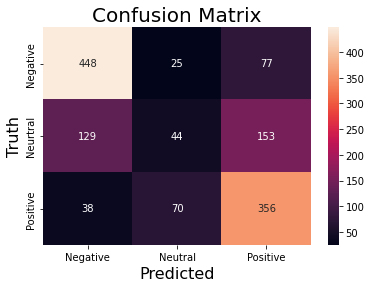

In [38]:
fig = plt.figure()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Truth', fontsize=16)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_yticklabels(['Negative', 'Neurtral', 'Positive'])
for tick in ax.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")
fig.savefig(root_folder + 'confusion_matrix_lstm_conv')

## ROC Curve

In [0]:
probas = model.predict(x_test).flatten()

In [0]:
## Lower Bound
replace_dict = {-1: 1, 0: 0, 1: 0}
roc_y_test = np.array([replace_dict[x] for x in y_test])

In [0]:
def find_best_thresh(fpr, tpr, threshold):
    roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': threshold})
    roc['dist'] = roc.apply(lambda row: np.sqrt(row['fpr'] ** 2 + (1 - row['tpr'])**2), axis=1)
    return roc.sort_values('dist').head().iloc[0]['threshold']

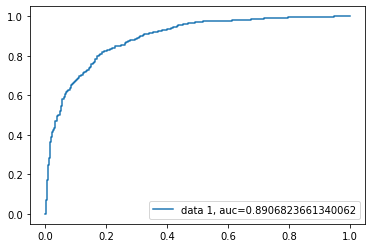

In [39]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(roc_y_test,  1 - probas)
auc = metrics.roc_auc_score(roc_y_test, 1 - probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [40]:
LOWER_BOUND = find_best_thresh(fpr, tpr, threshold)
LOWER_BOUND

0.4078262448310852

In [0]:
## Upper Bound
replace_dict = {-1: 0, 0: 0, 1: 1}
roc_y_test = np.array([replace_dict[x] for x in y_test])

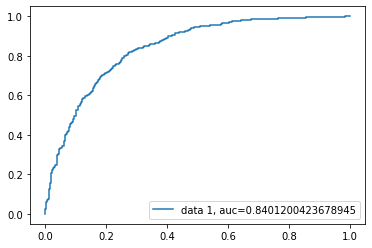

In [42]:
fpr, tpr, threshold = metrics.roc_curve(roc_y_test,  probas)
auc = metrics.roc_auc_score(roc_y_test, probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [0]:
UPPER_BOUND = find_best_thresh(fpr, tpr, threshold)

In [44]:
UPPER_BOUND

0.620917797088623

In [48]:
p = predict(model, x_test, y_test.astype(int))

[[448  61 106]
 [ 25  14 100]
 [ 77  31 478]]
0.7014925373134329


In [0]:
cm = confusion_matrix(p[0], y_test.astype(int).flatten())

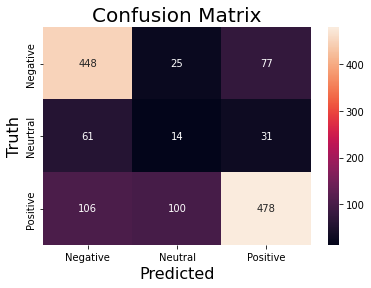

In [50]:
fig = plt.figure()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('Truth', fontsize=16)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_yticklabels(['Negative', 'Neurtral', 'Positive'])
for tick in ax.yaxis.get_majorticklabels():
    tick.set_verticalalignment("center")
fig.savefig(root_folder + 'confusion_matrix_lstm_conv')

# San Francisco Data

In [0]:
df = pd.read_csv(root_folder + 'data/sf_tweets/bay_area.csv')

In [46]:
df.head()

,text,location,coords,city,county
0,@RealYungYogi Hey there! We would be happy to check into that issue for you. Send us a DM with your account email and we will get it figured out!,"San Francisco, CA",NaN,San Francisco,San Francisco
1,The SI Class of 2005 had dinner tonight together for their 1st class virtual happy hour in celebration of the #sifoodshare2020 The appetizers are papusas. https://t.co/xfMyLVMpft,"San Francisco, California, USA",NaN,San Francisco,San Francisco
2,@abcdefghijkLMAO What a little slice of heaven https://t.co/k59ibwcVra,"Oakland, CA",NaN,Oakland,Alameda
3,"so next time I deal with this nightmare I'm gonna go for one of the backup ideas:\nmake a chrome extension which implements a ""remote-scroll"" API, so I can instead just trigger it that way.","Milpitas, CA",NaN,Milpitas,Santa Clara
4,I wasn’t ready for the end of Waco https://t.co/804eSGAF7F,"Oakland, CA",NaN,Oakland,Alameda


In [0]:
sf_tokens = tokenizer.texts_to_sequences(df['text'].values)
sf_tokens = pad_sequences(sf_tokens,maxlen=input_len )

In [48]:
sf_predictions = predict(model, sf_tokens, np.zeros(len(sf_tokens)))

[[     0      0      0]
 [ 66651  31338 137455]
 [     0      0      0]]
0.13310171420804948


In [0]:
df['sentiment'] = sf_predictions[0]

In [50]:
df.head()

,text,location,coords,city,county,sentiment
0,@RealYungYogi Hey there! We would be happy to check into that issue for you. Send us a DM with your account email and we will get it figured out!,"San Francisco, CA",NaN,San Francisco,San Francisco,1
1,The SI Class of 2005 had dinner tonight together for their 1st class virtual happy hour in celebration of the #sifoodshare2020 The appetizers are papusas. https://t.co/xfMyLVMpft,"San Francisco, California, USA",NaN,San Francisco,San Francisco,1
2,@abcdefghijkLMAO What a little slice of heaven https://t.co/k59ibwcVra,"Oakland, CA",NaN,Oakland,Alameda,1
3,"so next time I deal with this nightmare I'm gonna go for one of the backup ideas:\nmake a chrome extension which implements a ""remote-scroll"" API, so I can instead just trigger it that way.","Milpitas, CA",NaN,Milpitas,Santa Clara,0
4,I wasn’t ready for the end of Waco https://t.co/804eSGAF7F,"Oakland, CA",NaN,Oakland,Alameda,1


In [51]:
df.tail()

,text,location,coords,city,county,sentiment
235439,@Gunntwitt There sure was. You dialed “popcorn”.,"Fremont, CA",NaN,Fremont,Alameda,1
235440,Star Wars Sand People Figure https://t.co/6CXyUqSKgW https://t.co/61ITnRCSuB,"San Francisco, CA",NaN,San Francisco,San Francisco,1
235441,@NGSSMadeMeDoIt @exploratorium @tiktok_us Love the generator light! Great addition!,"San Francisco, CA",NaN,San Francisco,San Francisco,1
235442,looks out for one another and provides. All we have is each other - solidarity forever!,"San Francisco, CA",NaN,San Francisco,San Francisco,1
235443,Some niggas think they won't get caught slippin you respect the RASPADO MAN https://t.co/eDfdXICMe2,"San Jose, CA",NaN,San Jose,Santa Clara,1


In [0]:
df.to_csv(root_folder + 'data/sf_tweets/sentiments.csv', header=True, index=False)

In [0]:
city_sentiments = df.groupby('city')['sentiment'].mean().to_frame().reset_index()

In [54]:
city_sentiments.sort_values('sentiment', ascending=False).tail()

,city,sentiment
79,San Pablo,0.143590
48,Monte Sereno,0.142857
47,Milpitas,0.138243
92,Union City,0.121951
31,Gilroy,-0.153846


In [0]:
city_sentiments.to_csv(root_folder + 'data/sf_tweets/bay_area_sentiments.csv', header=True, index=False)

In [0]:
def diff_agg(grp):
    num = sum(grp)
    denom = sum(grp == 1) + sum(grp == -1)
    return num / denom

In [0]:
diff_city_sentiments = df.groupby('city')['sentiment'].agg(diff_agg).to_frame().reset_index()

In [0]:
comparison = city_sentiments.merge(diff_city_sentiments, on='city')

In [59]:
comparison.head()

,city,sentiment_x,sentiment_y
0,Alameda,0.338677,0.387911
1,Albany,0.317460,0.373134
2,American Canyon,0.250923,0.285714
3,Antioch,0.197541,0.225023
4,Atherton,0.292857,0.322835


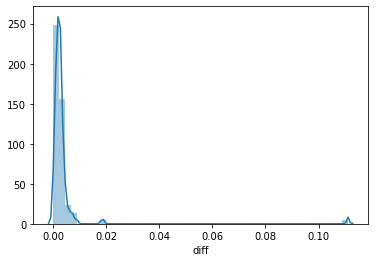

In [60]:
comparison['diff'] = (comparison['sentiment_x'] - comparison['sentiment_y']) ** 2
sns.distplot(comparison['diff'])

In [61]:
comparison.sort_values('diff', ascending=False).head()

,city,sentiment_x,sentiment_y,diff
69,Rio Vista,0.666667,1.000000,0.111111
50,Morgan Hill,0.500000,0.636364,0.018595
74,San Carlos,0.448339,0.541203,0.008624
71,Ross,0.166667,0.250000,0.006944
18,Cotati,0.250000,0.333333,0.006944


In [62]:
comparison['diff'].mean()

0.0035066354044437508

## Clustering

In [0]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [0]:
# cluster based on different sentiments

In [0]:
def get_tokens(s):
    x = tokenizer.texts_to_sequences(s)
    return pad_sequences(x, maxlen=input_len)

In [0]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]
neutral = df[df['sentiment'] == 0]

In [0]:
pos_tokens = get_tokens(positive['text'])
neg_tokens = get_tokens(negative['text'])
neu_tokens = get_tokens(neutral['text'])

### KMeans

In [0]:
!pip install kneed

In [0]:
from kneed import KneeLocator

Knee/Elbow plots

In [0]:
def k_means(data):
    wcss = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 10), wcss)
    plt.show()
    kneedle = KneeLocator(range(1, 10), wcss, curve='convex', direction='decreasing')
    print('Knee: {0}, Elbow: {1}'.format(kneedle.knee, kneedle.elbow))


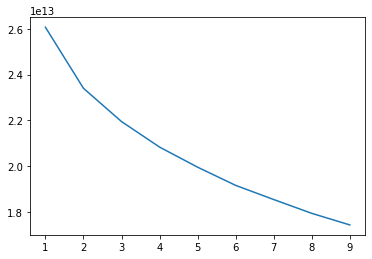

Knee: 4, Elbow: 4


In [0]:
k_means(pos_tokens)

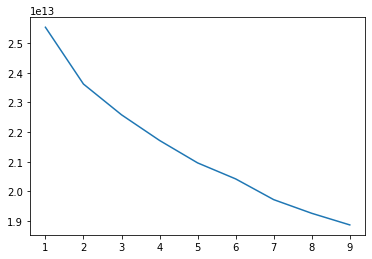

Knee: 4, Elbow: 4


In [0]:
k_means(neg_tokens)

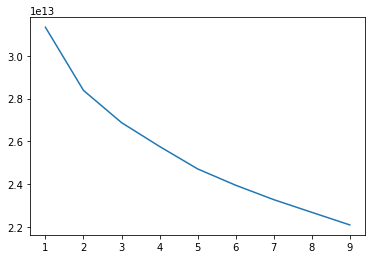

Knee: 3, Elbow: 3


In [0]:
k_means(neu_tokens)

Sillouette Plots

For n_clusters = 4 The average silhouette_score is : 0.1706274467066379
For n_clusters = 4 The average silhouette_score is : 0.18208169690229278
For n_clusters = 3 The average silhouette_score is : 0.1982584806591356


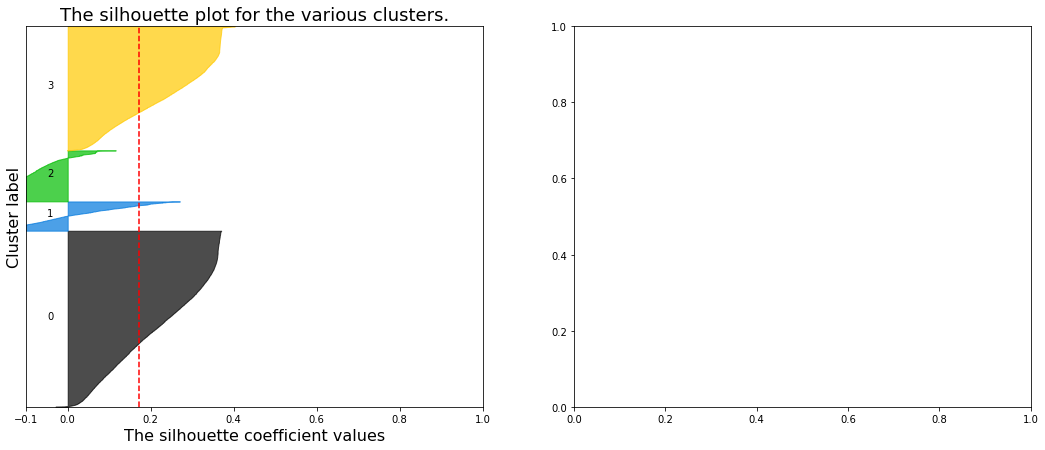

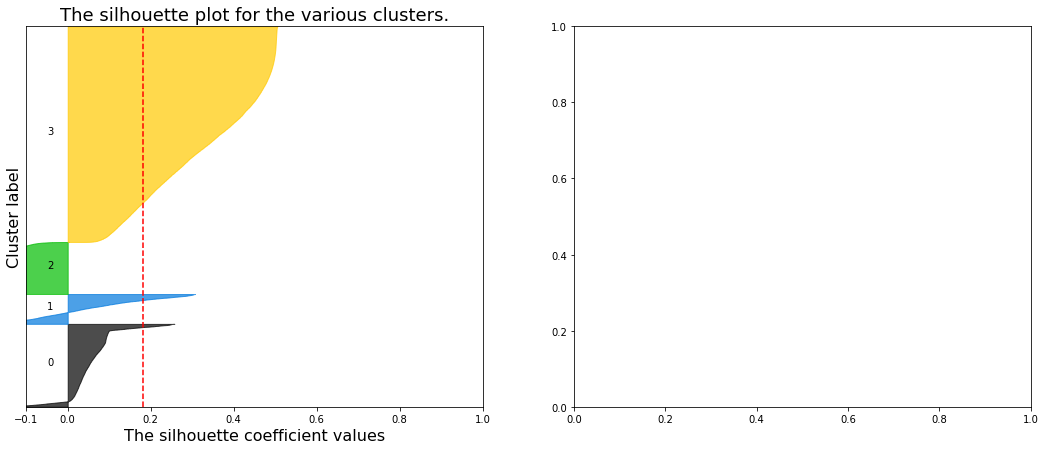

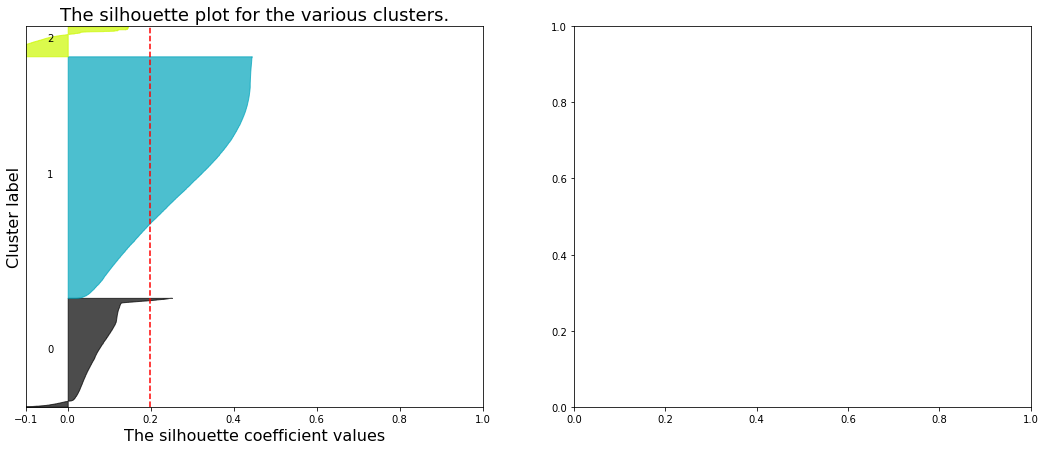

In [0]:
vals = zip([pos_tokens, neg_tokens, neu_tokens], [4, 4, 3])
for y, n_clusters in vals:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(y) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(y, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(y, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=18)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=16)
    ax1.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

### Agglomerative [CASE STUDY: BERKELEY]

In [0]:
from scipy.cluster import hierarchy

In [0]:
b_df = df[df['city'] == 'Berkeley']

In [0]:
positive = b_df[b_df['sentiment'] == 1]
negative = b_df[b_df['sentiment'] == -1]
neutral = b_df[b_df['sentiment'] == 0]

In [0]:
pos_tokens = get_tokens(positive['text'])
neg_tokens = get_tokens(negative['text'])
neu_tokens = get_tokens(neutral['text'])

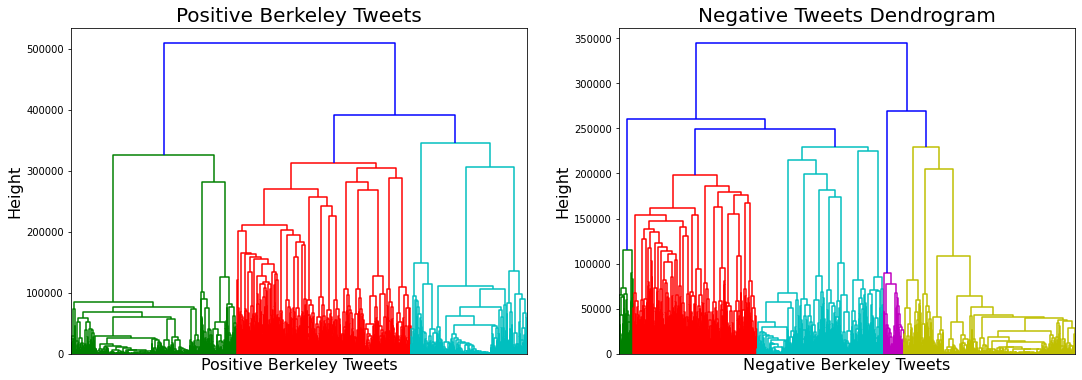

In [70]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
Z = hierarchy.linkage(pos_tokens, 'ward')
dn = hierarchy.dendrogram(Z)
plt.title('Positive Berkeley Tweets', fontsize=20)
plt.xticks([], [])
plt.xlabel('Positive Berkeley Tweets', fontsize=16)
plt.ylabel('Height', fontsize=16)

plt.subplot(122)
Z = hierarchy.linkage(neg_tokens, 'ward')
dn = hierarchy.dendrogram(Z)
plt.title('Negative Tweets Dendrogram', fontsize=20)
plt.xticks([], [])
plt.xlabel('Negative Berkeley Tweets', fontsize=16)
plt.ylabel('Height', fontsize=16)


plt.savefig(root_folder + 'dend.png', format='png', bbox_inches='tight')

In [0]:
def token_clustering(n_clusters, tokens):
    hc = AgglomerativeClustering(n_clusters = n_clusters,
                                 affinity='euclidean',
                                 linkage='ward')
    y_hc = hc.fit_predict(tokens)
    return y_hc

In [0]:
hc_pos = token_clustering(3, pos_tokens)

In [0]:
hc_neg = token_clustering(5, neg_tokens)

In [0]:
hc_neu = token_clustering(3, neu_tokens)

In [0]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [75]:
positive['cluster'] = hc_pos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
negative['cluster'] = hc_neg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
neutral['cluster'] = hc_neu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
pos_dict_c0, pos_dict_c1, pos_dict_c2= {}, {}, {}
def word_count(sentence, d):
    words = sentence.replace(',', '').replace('.', '').lower().split()
    words = [w for w in words if w not in stopwords]
    for word in words:
        if d.get(word):
            d[word] += 1
        else:
            d[word] = 1

In [82]:
pos_c0 = positive[positive['cluster'] == 0]
throw = list((map(lambda x: word_count(x, pos_dict_c0), pos_c0['text'])))
pd.DataFrame({'word': list(pos_dict_c0.keys()), 'count': list(pos_dict_c0.values())}).sort_values('count', ascending=False).head(20)

,word,count
108,rt,116
274,may,59
271,love,53
347,good,48
635,like,46
746,one,41
276,-,38
314,new,38
245,today,35
207,first,34


- New: happy about receiving something new (new job, new earrings), news that isn't mainstream
- Loving things
- Today: celebrating things happening today
- Check: Advertising (check out our ...)
- UC Berkeley Accounts
- This cluster is about a general group, less individual

In [83]:
pos_c0[pos_c0['text'].str.lower().str.contains('check')]

,text,location,coords,city,county,sentiment,cluster
4926,"Check out Day 7: Last Day, Mission Accomplished. #COVID19 #NYC #BackToReality https://t.co/MKcl3fgnYO via @YouTube","Berkeley, CA",NaN,Berkeley,Alameda,1,0
10604,"@tigerjosephs @fsanin The art was done by our talented artist, Matthew Arnone! 😊 You can check out most of his work here: https://t.co/m3Nv0KSYYb","Berkeley, CA",NaN,Berkeley,Alameda,1,0
16646,"@eWords Just listened to the reveal piece - this shit is so much bigger than just Facebook and the studios, it’s game “engines” and 3rd party ad tech companies having a free-for-all with user data unchecked. I’ve worked for one and the employee cognitive dissonance is next level.","Berkeley, California",NaN,Berkeley,Alameda,1,0
29179,"Best phone call of the day.\nMe: ""are you a registered Democrat? ""\nWoman: ""yes! And also my... Actually let me just check if I need to break up with my boyfriend... Honey? Are you registered as a Democrat or a Republican?"" #MA04 #mapoli @natalialinou https://t.co/7NE3JBYgo7","Berkeley, CA",NaN,Berkeley,Alameda,1,0
48766,Check out what I just added to my closet on Poshmark: ❤️⚡️ALL MUST GO SALE❤️BUNDLE FOR LOW OFFER!. https://t.co/hpMefxsAPk via @poshmarkapp #shopmycloset,"Berkeley, CA",NaN,Berkeley,Alameda,1,0
71606,Check out aliciahuitron101's video! #TikTok https://t.co/GKyF2AGATr,"Berkeley, CA",NaN,Berkeley,Alameda,1,0
72604,Check out aliciahuitron101's video! #TikTok https://t.co/NStqkqYR17,"Berkeley, CA",NaN,Berkeley,Alameda,1,0
77073,"@CFBHome If you are interested in good stories, check out the story about former @CalFootball QB Joe Roth. https://t.co/dJ8Jesu7Xu","Berkeley, California",NaN,Berkeley,Alameda,1,0
77811,Check out aliciahuitron101's video! #TikTok https://t.co/IHCl21NMgc,"Berkeley, CA",NaN,Berkeley,Alameda,1,0
80454,"RT @IanHaneyLopez: Thanks for the great conversation, and careful editing. Folks should make sure to check out the transcript as well. http…","Berkeley, California",NaN,Berkeley,Alameda,1,0


In [84]:
pos_c1 = positive[positive['cluster'] == 1]
throw = list((map(lambda x: word_count(x, pos_dict_c1), pos_c1['text'])))
pd.DataFrame({'word': list(pos_dict_c1.keys()), 'count': list(pos_dict_c1.values())}).sort_values('count', ascending=False).head(10)

,word,count
46,rt,139
140,like,104
165,good,96
221,love,92
1197,thank,90
31,know,75
95,i’m,67
377,one,64
39,thanks,64
62,it’s,58


- thank: Thanking people! Short and sweet (normally @-someone- Thanks!)
- Individual happiness, how they're happy from something they did or something they experienced, or someone made them happy
- Gratefulness

In [85]:
pos_c1[pos_c1['text'].str.lower().str.contains("love")]

,text,location,coords,city,county,sentiment,cluster
3753,"@kbguzzo If you think about it, it's kind of like fancy mac and cheese. What's not to love?","Berkeley, CA",NaN,Berkeley,Alameda,1,1
4438,@MontePooleNBCS Great things happen to great people! Love @Trevornoah @TheDailyShow !,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
8151,@Sirkeemer3000 Love yourself toots,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
12050,"im literally in love with Zoe Kravitz like, omg what a fucking WOMAN","Berkeley, CA",NaN,Berkeley,Alameda,1,1
13312,@SickSpaceHair Delighted to hear how much you love this!,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
16356,@edyong209 I loved that story.,"Berkeley, California",NaN,Berkeley,Alameda,1,1
16712,Sex ain’t better than love,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
20614,@cbrewsayso we love you so much courtney 💝,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
24516,@lovetolerk GENIUS AGAIN,"Berkeley, CA",NaN,Berkeley,Alameda,1,1
28588,"haven’t been back here in so long but i love the bangtannies as much as ever if not more 😭💜 MOTS:7 is EVERYTHING I’ve been keeping up with all the new music, not so much other content, but I’ll get to it all one day :’)) for now... JUNGKOOK’s VOICE N TATTOOS THANK YOU 🙏🏻😭","Berkeley, CA",NaN,Berkeley,Alameda,1,1


In [86]:
pos_c2 = positive[positive['cluster'] == 2]
throw = list((map(lambda x: word_count(x, pos_dict_c2), pos_c2['text'])))
pd.DataFrame({'word': list(pos_dict_c2.keys()), 'count': list(pos_dict_c2.values())}).sort_values('count', ascending=False).head(10)

,word,count
68,rt,255
550,&amp;,173
94,like,142
205,-,120
515,may,119
441,one,116
66,new,112
14,us,99
267,get,89
739,it’s,89


- Similar to the previous cluster, but more about other people's happiness, wishing other people well or sharing other people's discoveries

In [87]:
pos_c2[pos_c2['text'].str.lower().str.contains('good')]

,text,location,coords,city,county,sentiment,cluster
1219,"So yeah, I don’t know\n\nI can see that with the pandemic potentially Goodeggs could be doing good business\n\nIf there’s still some sort of interest from that company in me then what is it?","Berkeley, CA",NaN,Berkeley,Alameda,1,2
1225,"Ok, thought of a subject to ramble on about\n\nGoodeggers, I’m not sure if they’re still affiliated or if that’s just the common thread that binds them\n\nThey saw some personal notes 📝 I made on my laptop about how I need to harness the attention I get personally + professionally","Berkeley, CA",NaN,Berkeley,Alameda,1,2
3960,Developing a Practical Model for Ethical AI in the Business World: Introduction via @amalgaminsights https://t.co/qcUaH79GpR #aiforgood #ethicalai,"Berkeley, CA",NaN,Berkeley,Alameda,1,2
4551,So good I had to share! Check out all the items I'm loving on @Poshmarkapp from @jacquebensaid #poshmark #fashion #style #shopmycloset #lululemonathletica #mpg: https://t.co/koESouOBK2 https://t.co/YLAwdG8aFC,"Berkeley, CA",NaN,Berkeley,Alameda,1,2
4815,I guess the one good thing about the pandemic so far is to see how empty so much political posturing was\n\nI believe my stands will hold up the test of time\n\nBest illustrated if I can stay standing up\n\nIn every sense of the word 👻,"Berkeley, CA",NaN,Berkeley,Alameda,1,2
8754,"@HaveSomeSense @JoeySalads As a healthy 47 year old practicing proper social distancing measures, that is definitely true! Good to see there’s still some people out here with a head on their shoulders 🙌","Berkeley, CA",NaN,Berkeley,Alameda,1,2
13731,Respect to the @zoom_us codec team. Who knew that thousands of people would be livestreaming concerts over tight bandwidth for three or four months?\n\nI'd be glad if audio merely didn't suck. It's actually pretty good. And the video is *really* good.,"Berkeley, California",NaN,Berkeley,Alameda,1,2
25578,"@_djpn @reaIDickMNixon good to have a local guide weigh in on these things\n\nsometimes I visit a place and I'm like hmmm, what attractions have parking for my oil tanker? https://t.co/YCmvJw1nBL","Berkeley, CA",NaN,Berkeley,Alameda,1,2
25907,"@Trav_82 @raorob77 And Calhoun is a good trainer, too. His horses almost always show up.","Berkeley, CA",NaN,Berkeley,Alameda,1,2
27272,@Trav_82 @raorob77 Good luck Travis. It doesn’t seem like there is any reason to suspect he’s not going to run really well again today. He’s never faced a field like this before but I think he’s up for the challenge.,"Berkeley, CA",NaN,Berkeley,Alameda,1,2


In [88]:
len(pos_c0), len(pos_c1), len(pos_c2)

(1505, 2145, 2242)

In [0]:
neg_dict_c0, neg_dict_c1, neg_dict_c2, neg_dict_c3, neg_dict_c4 = {}, {}, {}, {}, {}

These first two clusters are pretty similar, the difference being the lengths of the tweets. This first cluster about systems in place negatively affecting their lifes. The similarity is within the tone, where people are disappointed in a lot of things, the federal government, COVID-19, Trump, Biden, etc.

In [81]:
neg_c0 = negative[negative['cluster'] == 0]
throw = list((map(lambda x: word_count(x, neg_dict_c0), neg_c0['text'])))
pd.DataFrame({'word': list(neg_dict_c0.keys()), 'count': list(neg_dict_c0.values())}).sort_values('count', ascending=False).head(20)

,word,count
60,like,72
15,i’m,62
91,one,50
263,really,47
325,get,43
6,time,42
129,want,40
72,i'm,40
98,never,38
394,it’s,38


In [82]:
neg_c0[neg_c0['text'].str.lower().str.contains('one')]

,text,location,coords,city,county,sentiment,cluster
3572,"@csferreira08 woW i missed that one \nand fuck that, truly","Berkeley, CA",NaN,Berkeley,Alameda,-1,0
4043,@jurivision @ManishEarth Someone said they were closed - do you know if they've closed down? :&lt;,"Berkeley, CA",NaN,Berkeley,Alameda,-1,0
7899,@Vitricate Idk why he thinks it only goes one way,"Berkeley, CA",NaN,Berkeley,Alameda,-1,0
8460,Everyone on TV uses infer wrong.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,0
9894,@washingtonpost Hell no. Anyone calling for this is someone to block automatically.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,0
10108,"@LadyTrashBag Oh believe me, I take it that way as well. At that point I start going down to the range to get back in practice.\n\nOne factor in my favor is that I currently attend a mosaue in Blackest Oakland, half of whose membership are ex-cons and/or ex FOI. We take security seriously.","Berkeley, CA",NaN,Berkeley,Alameda,-1,0
10757,"@LadyTrashBag I made a point of going to see such places whenever I could - Tuol Sleng prison in Cambodia, Hiroshima Peace Park museum, a few others. The one that hit hardest somehow was Anne Frank Huis in Amsterdam. I was in a funk the whole day after that.😢","Berkeley, CA",NaN,Berkeley,Alameda,-1,0
10982,"@trogdor8768 Yes, it’s totally not at all suspicious to giddily tweet about how you intend to accuse someone of raping you https://t.co/IAXmu9C6tM","Berkeley, CA",NaN,Berkeley,Alameda,-1,0
12745,@TAizenberg Read this piece of “journalism” and it’s all hearsay bullshit. Literally shouldn’t even be written about because someone’s marital life is none of the public’s business but there is no “scandal” here.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,0
13694,"@amateratsukirin oh fuck I'm so sorry you ran into them! Yeah, I'm honestly done with it all together it's just too unsafe","Berkeley, CA",NaN,Berkeley,Alameda,-1,0


In [83]:
neg_c1 = negative[negative['cluster'] == 1]
throw = list((map(lambda x: word_count(x, neg_dict_c1), neg_c1['text'])))
pd.DataFrame({'word': list(neg_dict_c1.keys()), 'count': list(neg_dict_c1.values())}).sort_values('count', ascending=False).head(20)

,word,count
184,like,60
163,people,57
447,rt,45
145,one,41
368,i’m,37
67,get,35
164,need,32
186,would,28
136,us,26
29,day,25


In [84]:
neg_c1[neg_c1['text'].str.lower().str.contains("people")]

,text,location,coords,city,county,sentiment,cluster
3973,"@QPatriot17 These people need to be arrested, AFTER a public ass kicking.","Berkeley, CA",NaN,Berkeley,Alameda,-1,1
8455,Disabled people have sex. https://t.co/cHUdzhPqcj,"Berkeley, CA",NaN,Berkeley,Alameda,-1,1
13959,"And people ask me why I don't want to move back to Orange County, part 2 https://t.co/YG2dCGmYEm","Berkeley, CA",NaN,Berkeley,Alameda,-1,1
14013,And people ask me why I don't want to move back to Orange County https://t.co/sbzFg0Pg1p,"Berkeley, CA",NaN,Berkeley,Alameda,-1,1
21361,"@LadyTrashBag I have. Taking the potential threat seriously doesn't mean I'm required to take THEM seriously as people. The one thing these sorts of misfits can't deal with is being made fun of.\n\nI do take your point, but I decline to view these fools with more than contempt.","Berkeley, CA",NaN,Berkeley,Alameda,-1,1
28336,RT @DarwinBondGraha: There was a small fire inside the Radisson Hotel in East Oakland last night where homeless people are being housed dur…,"Berkeley, CA",NaN,Berkeley,Alameda,-1,1
36751,@mma_marxian wtf is wrong with these people lmao,"Berkeley, CA",NaN,Berkeley,Alameda,-1,1
38151,"I just saw some kid fall off of his skateboard \n\nBe careful people, build up don’t breakdown\n\nSays the guy who’s been bitching about old baggage 🧳 \n\nWhat 🤷🏻 I was backed up...Figuratively!","Berkeley, CA",NaN,Berkeley,Alameda,-1,1
41679,"RT @JesseArreguin: Starting Monday, we will be able to test all Berkeley residents and workers who are symptomatic. People need to set up a…","Berkeley, CA",NaN,Berkeley,Alameda,-1,1
42252,Throughout all of the discussion about the economic impact of #COVID19 I hear nothing about how it will impact young people. If this recession is anything like the last people entering the workforce will be forever left behind if the gov does nothing.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,1


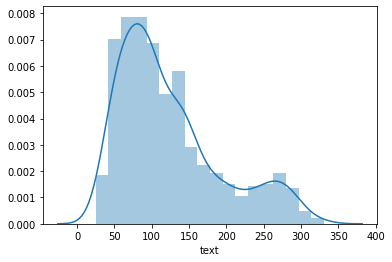

In [89]:
sns.distplot(neg_c1['text'].apply(len))

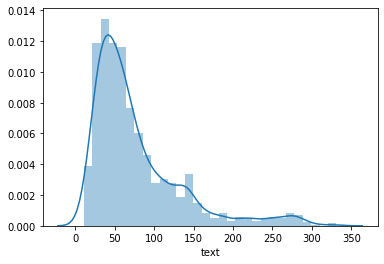

In [90]:
sns.distplot(neg_c0['text'].apply(len))

In [101]:
neg_c2 = negative[negative['cluster'] == 2]
throw = list((map(lambda x: word_count(x, neg_dict_c2), neg_c2['text'])))
pd.DataFrame({'word': list(neg_dict_c2.keys()), 'count': list(neg_dict_c2.values())}).sort_values('count', ascending=False).head(20)

,word,count
71,like,14
82,think,12
0,rt,10
134,know,8
95,way,7
18,it’s,6
133,much,6
471,miss,5
123,oh,5
158,croissant,5


Misc

In [102]:
neg_c2

,text,location,coords,city,county,sentiment,cluster
4017,"RT @ShahidForChange: In a nutshell, this is why I’m running to #ReplacePelosi.\n\nOur Republic is in crisis. While the GOP openly promotes fa…","Berkeley, CA ↔️ Sacramento, CA",NaN,Berkeley,Alameda,-1,2
5248,"@NBCSWarriors No, Green has his own identity!","Berkeley, CA",NaN,Berkeley,Alameda,-1,2
7536,“It’s not Ben Shapiro it’s Ben Sharpie-ro” -my Danish Roomate,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
7595,"@B52Malmet The Trump Crime Family wants a cut of any cure or vaccine. Apparently, Gilead won’t wet his beak.","Berkeley, CA",NaN,Berkeley,Alameda,-1,2
8618,I just wanna be on a jet ski in Tahoe 🙄,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
10135,@SyberXenon @FlipBunny forbidden condiment,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
13504,RT @nikkoremigio: Just watched this... Lit a fire in me for real. @DeSeanJackson10 the coldest,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
15596,If you’re going towards Richmond it’s a bad accident. Exit Carlson &amp; get back on past Mc. Donald,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
21150,@LMplusG @CheriJacobus Trump is quite profitable for a network like MSNBC,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2
25249,RT @brelandjr_: Being in the house was my thing now I don’t wanna be in this mf 😂,"Berkeley, CA",NaN,Berkeley,Alameda,-1,2


In [103]:
neg_c3 = negative[negative['cluster'] == 3]
throw = list((map(lambda x: word_count(x, neg_dict_c3), neg_c3)))
pd.DataFrame({'word': list(neg_dict_c3.keys()), 'count': list(neg_dict_c3.values())}).sort_values('count', ascending=False).head(10)

,word,count
0,text,1
1,location,1
2,coords,1
3,city,1
4,county,1
5,sentiment,1
6,cluster,1


This cluster is only news and media, very few personal Twitter accounts. Mostly about current situation

In [104]:
neg_c3

,text,location,coords,city,county,sentiment,cluster
232,This is frightening. https://t.co/hfF6Rqpedl,"Berkeley, CA",NaN,Berkeley,Alameda,-1,3
1233,"Now #TaraReade is claiming that her written complaint didn’t use the term sexual harassment, but that there may have been a box that she checked for harassment, but we won’t know till we see the form!\n\nThis woman needs some serious psychological counseling.https://t.co/k6Hac5JjjJ","Berkeley, CA",NaN,Berkeley,Alameda,-1,3
2321,Technology has gone too far when it attempts to fix the inconvenience of being human.,"Berkeley, California",NaN,Berkeley,Alameda,-1,3
4811,"Discussing a sexual harassment accusation against Biden, McEnany said Trump “always told the truth on these issues,” ignoring his evasions and misrepresentations in responding to dozens of accusations against him. @PressSec @WhiteHouse","Berkeley, California",NaN,Berkeley,Alameda,-1,3
6937,"@JoeBiden Start to finish, this is the Trump Pandemic. Period. Full stop.","Berkeley, CA",NaN,Berkeley,Alameda,-1,3
10264,"And there it is. It has begun, the downplaying of violence against women and sexual assault in order to morally justify another old, stale, dementia having, spineless, white, career politician aligned w the corporate elite. https://t.co/WblitIt3Hr","Berkeley, CA",NaN,Berkeley,Alameda,-1,3
14648,.@DavidAJaeger ever use August CPS from 1967 and 1968? They have tobacco supps. I’ve asked all the usual Princeton labor econ suspects but haven’t yet gotten ahold of David Card. IPUMS may have the data unprocessed yet but not clear,"Berkeley, CA",NaN,Berkeley,Alameda,-1,3
14696,"Don’t you just wish this is what you’re having for dinner tonight? One can only hope... Until then, once again, stay home, stay safe, and don’t forget to wash your hands.\n#slipperyfishcatering #slipperyfishsushi #sushicatering #sushichef #livesushibar #nigiri #sashimi #catering https://t.co/9TAkeTskcA","Berkeley, CA",NaN,Berkeley,Alameda,-1,3
17809,⁦@sebastianpinera⁩ The worst president of #Chile after #Pinochet ! #HumanRights #PoliceBrutality #Corruption https://t.co/HNEYZI61Mx,"Berkeley, California",NaN,Berkeley,Alameda,-1,3
17966,"RT @RoKhanna: There are 60 million essential workers keeping this nation moving and too many lack living wages, adequate benefits, and COVI…","Berkeley, California",NaN,Berkeley,Alameda,-1,3


In [105]:
neg_c4 = negative[negative['cluster'] == 4]
throw = list((map(lambda x: word_count(x, neg_dict_c4), neg_c4['text'])))
pd.DataFrame({'word': list(neg_dict_c4.keys()), 'count': list(neg_dict_c4.values())}).sort_values('count', ascending=False).head(20)

,word,count
88,like,84
202,&amp;,74
20,one,68
211,people,63
481,would,58
308,get,55
448,time,55
455,us,53
942,even,52
153,think,49


14% corona virus and quarantine. Interesting to note that there are many more tweets about the virus and the government's reaction compared to quarantine struggles. Furthermore, there's a far greater hatred this week on Biden (perhaps since he's been in the news). It shows the fallout he can have in primarily blue residences. Angry politics. Much angrier tone.

In [107]:
neg_c4[neg_c4['text'].str.lower().str.contains("people")]

,text,location,coords,city,county,sentiment,cluster
3804,"@ciphergoth not really paying attention to Trump, personally; there's enough mendacity &amp; monstrousness in the world that the choice of what to be continually outraged about is mostly a matter of taste (OK, some people claim to be utilitarians who choose causes objectively, but they're lying)","Berkeley, CA",NaN,Berkeley,Alameda,-1,4
13611,The genre of tweet that’s like “I can’t believe you HAD to go to the beach while my child / partner DIES ALONE of COVID!” - wait until these people hear about cars.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,4
17300,@yungmoomin tragedy of the commons is like a basic conservative myth lol what are these people talking about,"Berkeley, CA",NaN,Berkeley,Alameda,-1,4
19276,Remember when Anita Hill rejected Biden’s 2019 apology? Maybe people will listen to her now https://t.co/kv9o52GqG1,"Berkeley, CA",NaN,Berkeley,Alameda,-1,4
23142,"@kevnicss @nytimes All this, plus, idk, can't people just mind their own business?\n\nI get the need for safety but we've all been sitting inside for weeks now. The hospitals are empty, we have mask laws, if a lady wants to go get botox then why do we need to have a conversation about it?","Berkeley, CA",NaN,Berkeley,Alameda,-1,4
23458,@nytimes Who cares what elective procedures people want to get?\n\nEnforce mask laws and mind your own business. This petty tyranny bullshit has to stop.,"Berkeley, CA",NaN,Berkeley,Alameda,-1,4
33030,"@stealthygeek I guess for some it's unbelievable that Biden, with his well documented history of plagiarism, lies, and inappropriate behavior, couldn't be guilty of Reade's allegations. But those people are incredibly gullible fools who are going to lose another election to a senile racist","Berkeley, CA",NaN,Berkeley,Alameda,-1,4
36744,"RT @RBReich: This is the underlying motive, friends: Get rid of safety nets so people are forced back to work, even at risk of their lives.…","Berkeley, CA",NaN,Berkeley,Alameda,-1,4
38986,"@ProfMMurray But I realize that most people will get their news from Hannity or Maddow or the like, and I suspect they'll play clips of live arguments, so I agree that it will probably increase the exposure or most people to at least some clips of the Court's oral arguments.","Berkeley, California",NaN,Berkeley,Alameda,-1,4
42035,"No clue about the Future I mean lockdown life is weird even though I’m still on what I’m doing\n\nI still notice the overall changes, no clue what’s next, I mean if people go out and blow the curve up again, what then?\n\nNo, idea","Berkeley, CA",NaN,Berkeley,Alameda,-1,4


In [118]:
len(neg_c4[neg_c4['text'].str.lower().str.contains('|'.join(corona_keywords))]) / len(neg_c4)

0.1485148514851485

In [119]:
len(neg_c0), len(neg_c1), len(neg_c2), len(neg_c3), len(neg_c4)

(1115, 822, 134, 96, 808)

# Coronavirus Sentiment

In [0]:
corona_keywords = ['corona', 'covid', 'mask', 'quarantine', 'pandemic', 'virus', 'lockdown']

In [0]:
corona_bools = df['text'].str.lower().str.contains('|'.join(corona_keywords))

In [0]:
corona_tweets = df[corona_bools]

In [0]:
non_corona_tweets = df[~corona_bools]

In [68]:
corona_tweets['sentiment'].mean()

-0.1622323677581864

In [69]:
corona_tweets.groupby('county')['sentiment'].mean()

county
Alameda         -0.168658
Contra Costa    -0.104089
Marin           -0.179283
Napa             0.000000
San Francisco   -0.160442
San Mateo       -0.149864
Santa Clara     -0.172063
Solano          -0.160377
Sonoma          -0.210526
Name: sentiment, dtype: float64

In [70]:
corona_tweets.groupby('county').size()

county
Alameda          2846
Contra Costa     538 
Marin            251 
Napa             7   
San Francisco    5435
San Mateo        734 
Santa Clara      2749
Solano           106 
Sonoma           38  
dtype: int64

In [71]:
len(corona_tweets) / len(df)

0.053957628990333156

In [72]:
corona_tweets.head(50)

,text,location,coords,city,county,sentiment
57,Separating myths from facts is key to staying safe and healthy during the #coronavirus pandemic. We've debunked 10 common myths to keep you up-to-date on the facts. \n\nhttps://t.co/XKp608b2Ln,"Santa Clara, California",NaN,Santa Clara,Santa Clara,0
82,"@jaynordlinger Jay, important news from South Korea: One cannot catch COVID twice. https://t.co/JSJyzw5MOB\n\n(i know, off topic...but still)","Mountain View, CA",NaN,Mountain View,Santa Clara,-1
94,"@satdick the end of that article is definitely the key to pay attention to — it will be important to look back later on to see how sweden ended up doing in a few months, and i have a feeling there’s also a lot of cases going undetected in the US, just as they are there with no lockdown","Palo Alto, CA",NaN,Palo Alto,Santa Clara,0
102,"Excess U.S. deaths hit estimated 37,100 in pandemic's early days, far more than previously known https://t.co/ZVDGHNin5i","San Jose, CA",NaN,San Jose,Santa Clara,-1
118,@LetsGoBirdss @ClayTravis Just for the honeybees they! They have to quarantine until they flatten the curve!,"San Jose, CA",NaN,San Jose,Santa Clara,-1
125,"Excess U.S. deaths hit estimated 37,100 in pandemic’s early days, far more than previously known https://t.co/BZ7LuS2GVR","San Jose, California, USA",NaN,San Jose,Santa Clara,-1
136,"May is #MentalHealthAwarenessMonth! Be sure to take good emotional care of yourself and your loved ones during #coronavirus/#COVID19. For information and resources to support your mental well-being while social distancing and sheltering in place, visit https://t.co/imYkYBw8NY. https://t.co/f0L2k6QVAB","San Francisco, CA",NaN,San Francisco,San Francisco,1
139,@martymasks Then cut a hole into the center of the lid of the bucket.\n\nI used an inch and half inner diameter pvc and made a small loose hole with a hole saw. \n\nPlace the pipe in the hole then place a T connector at the bottom then cut from the top of the pipe about an,"San Jose, CA",NaN,San Jose,Santa Clara,-1
144,RT @BrendonWoodsPD: Public defenders are heroes! During this pandemic they’ve been fighting everyday despite overwhelming obstacles to get…,"Clayton, CA",NaN,Clayton,Contra Costa,1
184,Thank you for being part of our small tribe @jonstull 🙌🏾! Glad @davinciclub_ was able to support during these times ✨ #Homeschooling #WorkFromHome #COVID__19 https://t.co/8snKlsySeV,"San Francisco, CA",NaN,San Francisco,San Francisco,1
